## Fine-Tuning Vision Encoder Decoder Model for Image Captioning

### Elizabeth Trahadias, CS 733 Final Project

In this notebook, we fine-tune 4 different Vision Encoder-Decoder image captioning models. The models are fine-tuned and trained with Hugging Face's `Seq2SeqTrainer`.  **Please be advised if you run this code, each of the models take a long time to train (approximately ~25 minutes on my computer).**

### Load and Install Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
import urllib.request
import os
from pathlib import Path
import csv
import json
import requests
import time
from requests import exceptions
import cv2
import argparse

import torch

import re

import spacy
from unicodedata import normalize

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

In [2]:
# !pip install transformers
# !pip install spacy

In [2]:
import session_info
session_info.show()

### Cleaning the Text

Before training or using any sort of language models, the text needs to be pre-processed and tokenized. The pre-processing code was adapted from the tutorial given in one of the CS 733 classes. The source code can be found [here](https://github.com/Satwikram/AI-Tutoring/blob/main/NLP/FineTuning%20BERT%20for%20TEXT%20classification.ipynb). It was advised we could adapt this code for our projects.

In [3]:
# Read in data
df=pd.read_csv('BEES/Sources_captions.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      196 non-null    object
 1   file     196 non-null    object
 2   license  196 non-null    object
 3   note     196 non-null    object
 4   caption  196 non-null    object
dtypes: object(5)
memory usage: 7.8+ KB


In [5]:
nlp = spacy.load("en_core_web_sm") #remove stop words, lemmatization

def clean_data(df, column):

    def lem_stp():
        # lemmatization, remove stop words
        for doc in nlp.pipe(df[column], disable=["parser", "ner"], batch_size=512):
            yield " ".join(
                [d.lemma_ for d in doc if not d.is_stop]
            )
  
    def clean(text):

        text = str(text).strip()

        if text:
          #Normalize Text
            text = normalize("NFKD", text)
          #Remove links 
            text = re.sub(r'https?:\/\/.*?[\s+]', '', text.replace("|"," ") + " ")
          #Strip Punctation
            text = re.sub(r'[^\w\s]','', text)

        return text.strip()

    df[column] = df[column].apply(clean)
    df[column] = list(lem_stp())
    df[column] = df[column].apply(lambda x: re.sub("\s+", " ", x.strip()))
    # If less than 5 words, then remove from the df
    df[column] = df[column].apply(lambda x: x if len(x.split()) >= 5 else None)

    return df[column]

In [6]:
# Call the function to clean the captions
df['clean_captions']=clean_data(df, 'caption')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df['clean_captions']

0      Grey white black chalkbrood mummy sit wire screen
1      pile gray white chalkbrood mummy sit wire scre...
2      discolor chalkbrood mummy see lightly color ca...
3      gondola shape bee larva see open brood cell be...
4                 bee larva chalkbrood fungus spore grow
                             ...                        
189                       diseased pupa tongue cell wall
190                       diseased pupa tongue cell wall
191    Greasy sink perforate cell pupal tongue prepup...
192    Capping slightly remove black Sacbrood virus i...
193    White larva affect Sacbrood virus head raise b...
Name: clean_captions, Length: 194, dtype: object

In [7]:
# View the first part of the DataFrame
df.head()

url                    file  \
0  https://live.staticflickr.com/7466/27401150176...  BEES/Unhealthy/292.jpg   
1  https://live.staticflickr.com/7387/27435735775...  BEES/Unhealthy/293.jpg   
2  https://live.staticflickr.com/8681/16200799428...  BEES/Unhealthy/294.jpg   
3  https://live.staticflickr.com/7316/27030739643...  BEES/Unhealthy/295.jpg   
4  https://live.staticflickr.com/7296/16387517262...  BEES/Unhealthy/296.jpg   

  license        note                                            caption  \
0       0  chalkbrood  Grey white black chalkbrood mummy sit wire screen   
1       0  chalkbrood  pile gray white chalkbrood mummy sit wire scre...   
2       0  chalkbrood  discolor chalkbrood mummy see lightly color ca...   
3       0    sacbrood  gondola shape bee larva see open brood cell be...   
4       0  chalkbrood             bee larva chalkbrood fungus spore grow   

                                      clean_captions  
0  Grey white black chalkbrood mummy sit wire screen  
1  pile gray white chalkbrood mummy sit wire scre...  
2  discolor chalkbrood mummy see lightly color ca...  
3  gondola shape bee larva see open brood cell be...  
4             bee larva chalkbrood fungus spore grow

In [8]:
# Calculate the length (i.e. number of words) of the captions
length = [len(x.split()) for x in df['clean_captions']]

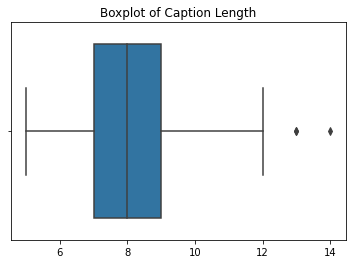

In [9]:
sns.boxplot(x=length)
plt.title("Boxplot of Caption Length")
plt.show()

We can see that approximately 50% of our captions have 8 words or less.

### Tokenize Text and Extract Image Features

This function below tokenizes the input text, extracts the features from the images, and then creates a training and a testing set. The input of the function allows us to specify the vision encoder and text tokenizer.

In [10]:
from transformers import VisionEncoderDecoderModel
from transformers import ViTFeatureExtractor
from PIL import Image
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [11]:
def CaptioningModel(samples, img_paths, pick_tokenizer, pick_feat_extractor):
    # pick_tokenizer = "bert-bees_final" # fine-tuned for our domain
    # pick_tokenizer = "scibert-bees-final" # fine-tuned for our domain
    # pick_tokenizer = "bert-base-uncased"
    # pick_tokenizer = "gpt2"
    sequence_length = 64

    tokenizer = AutoTokenizer.from_pretrained(pick_tokenizer)

    # the gpt2 model does not always automatically add the padding token
    # BERT adss this token automatically
    if pick_tokenizer == "gpt2" and tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token':'[PAD]'})
        tokenizer.pad_token = tokenizer.eos_token

    tokens = tokenizer(
      samples.tolist(), 
      max_length = sequence_length,
      truncation=True,
      padding="max_length",
      add_special_tokens=True,
      return_tensors="np")
    
    # Convert the tokenized text to a dataframe
    X_tokenized=pd.DataFrame({"input_ids": tokens["input_ids"].tolist()})
    
    # Image feature extractor
    feature_extractor = ViTFeatureExtractor.from_pretrained(pick_feat_extractor)
    
    # For each image, open from the file path,
    # and then apply the feature extractor
    def feat_extract(image):
        image = Image.open(image).convert("RGB")
        pixel_values = feature_extractor(image, return_tensors="np").pixel_values
        return(pixel_values.squeeze())
    
    pixel_values=[]
    file_paths = list(img_paths.values)
    for f in file_paths:
        pixel_values.append(feat_extract(f))
    
    # Add column to dataframe with the extracted image features
    X_tokenized['pixel_values'] = pixel_values
    
    # Word tokens are renamed to labels for the model
    X_tokenized.rename({'input_ids':'labels'}, axis=1, inplace=True)
    
    # Shuffle the data set
    X_tokenized.sample(frac=1,random_state=42).reset_index()

    # Create a training set and an evaluation set
    train_dataset = X_tokenized.iloc[:155]
    eval_dataset = X_tokenized.iloc[155:]

    train_dataset = train_dataset.to_dict('records')
    eval_dataset = eval_dataset.to_dict('records')
    
   
    return(tokenizer, feature_extractor, train_dataset, eval_dataset)

In [12]:
tokenizer, feature_extractor, train_dataset, eval_dataset = CaptioningModel(df['clean_captions'],
                                                                            df['file'],
                                                                            'bert-bees_final',
                                                                            "google/vit-base-patch16-224-in21k")

The [Vision Encoder Decoder Models](https://huggingface.co/docs/transformers/v4.25.1/en/model_doc/vision-encoder-decoder#transformers.VisionEncoderDecoderModel) from Hugging Face are capable of tasks like image captioning. For these models, a vision encoder extracts the features from the images, and then a language model creates the captions.

There is a very popular pre-trained image captioning model on Hugging Face's documentation page. It is called [vit-gpt2-image-captioning](https://huggingface.co/nlpconnect/vit-gpt2-image-captioning). We applied similar techniques from this methodology to fine-tune our image captioning model for our specific problem, particularly the `Seq2SeqTrainer()` to fine-tune all of our models.

Sources for parameters established below:
* https://ankur3107.github.io/blogs/the-illustrated-image-captioning-using-transformers/
* https://huggingface.co/nlpconnect/vit-gpt2-image-captioning
* https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/vision-encoder-decoder#transformers.TFVisionEncoderDecoderModel

#### Image Captioning Model 1: Google's ViT and our Pre-trained BERT

Source for model configuration: https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/vision-encoder-decoder#transformers.TFVisionEncoderDecoderModel


In [13]:
batch_size=16

# Define encoder-decoder model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k",
                                                                  'bert-bees_final',
                                                                  tie_encoder_decoder=True)
    
## DEFINE PARAMS ##
model.config.decoder_start_token_id = tokenizer.cls_token_id # caption start token
model.config.pad_token_id = tokenizer.pad_token_id # pad token
model.config.eos_token_id = tokenizer.sep_token_id # end of sentence token
model.config.vocab_size = model.config.decoder.vocab_size # vocab size

model.config.max_length = 20 # output length max
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 1
model.config.num_beams = 4 # for the beam search

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-bees_final and are newly initialized: ['bert.encoder.layer.1.crossattention.self.query.bias', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.encoder.layer.5.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.5.crossattention.self.value.bias', 'bert.encoder.layer.7.crossattention.output.dense.bias', 'bert.encoder.layer.3.crossattention.self.query.bias', 'bert.encoder.layer.2.crossattention.self.query.bias', 'bert.encoder.layer.4.crossattention.self.query.weight', 'bert.encoder.layer.6.crossattention.self.value.bias', 'bert.encoder.layer.10.crossattention.output.dense.bias', 'bert.encoder.layer.10.crossattention.output.dense.weight', 'bert.encoder.layer.6.crossattention.self.value.weight', 'bert.encoder.layer.11.crossattention.self.key.bias', 'bert.encoder.layer.4.crossattention.self.value.bias', 'bert.encoder.layer.4.crossattention.self.key.bias', 'bert.encoder.layer.7.crossatten

In [14]:
# ! pip install evaluate

In [15]:
# ! pip install rouge_score

#### Generate Function for Evaluation Metrics

Sources for metrics: 
* https://huggingface.co/docs/evaluate/choosing_a_metric
* https://huggingface.co/evaluate-metric
* https://huggingface.co/spaces/evaluate-metric/rouge
* https://huggingface.co/spaces/evaluate-metric/meteor
* https://huggingface.co/spaces/evaluate-metric/bleu

It is important to evaluate the model we are training. We will be using 3 common image captioning models to evaluate our model. We will be using ROUGE, BLEU, and METEOR.

In [16]:
## METRICS ##
# Source: https://huggingface.co/docs/transformers/main_classes/trainer
import evaluate

# Load eval metrics for text
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")

def compute_metrics(pred):
    labels_ids = pred.label_ids # our captions (labels)
    pred_ids = pred.predictions # predicted captions

    # Special tokens are removed (like PAD or SEP)
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True) # decode predictions
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id # remove special token
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True) # decode true captions

    # compute metrics, they will display as a dictionary
    rouge_result = rouge.compute(predictions=pred_str, references=label_str)
    bleu_result = bleu.compute(predictions=pred_str, references=label_str)
    meteor_result = meteor.compute(predictions=pred_str, references=label_str)
    
    return {"rouge_result": rouge_result, "bleu_result": bleu_result, "meteor_result":meteor_result}

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/elizabethtrahadias/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/elizabethtrahadias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/elizabethtrahadias/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Define Training Arguments and Use Seq2SeqTrainer

Hugging Face's `Seq2SeqTrainer` was used since we are attempting to generate new sentences based on a given input (i.e. the image). In this case, the image feature extractor is used as the tokenizer for the `Seq2SeqTrainer`. The training and evaluation data sets include two inputs: the pixel values for the images and the tokenized text.

In [17]:
# Create arguments for the Seq2Seq model
training_args = Seq2SeqTrainingArguments(
    output_dir='vit-bert-bees-final',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    warmup_steps=100,  
    num_train_epochs = 15, #TRAIN_EPOCHS
    save_total_limit=1,
    )


from transformers import default_data_collator

# Set up the trainer to fine tune the model
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
    )

In [18]:
# Fine-tune the model, training and evaluating on the train dataset trainer.train()
trainer.train()

/opt/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 155
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 150
  Number of trainable parameters = 224270394


***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  N

TrainOutput(global_step=150, training_loss=2.857837117513021, metrics={'train_runtime': 1295.1419, 'train_samples_per_second': 1.795, 'train_steps_per_second': 0.116, 'total_flos': 4.208860281701376e+17, 'train_loss': 2.857837117513021, 'epoch': 15.0})

In [19]:
vit_bert_bees = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 39
  Batch size = 16


In [20]:
vit_bert_bees

{'eval_loss': 0.6292902827262878,
 'eval_rouge_result': {'rouge1': 0.27766861511205404,
  'rouge2': 0.0369349311657004,
  'rougeL': 0.24327645289183747,
  'rougeLsum': 0.24323887525244992},
 'eval_bleu_result': {'bleu': 0.0,
  'precisions': [0.3689839572192513, 0.05405405405405406, 0.0, 0.0],
  'brevity_penalty': 0.5673125345545486,
  'length_ratio': 0.6382252559726962,
  'translation_length': 187,
  'reference_length': 293},
 'eval_meteor_result': {'meteor': 0.14410297953591264},
 'eval_runtime': 13.6828,
 'eval_samples_per_second': 2.85,
 'eval_steps_per_second': 0.219,
 'epoch': 15.0}

In [21]:
#trainer.save_model('image_captioning_model_vit_bert-bees')
trainer.save_model('vit-bert-bees-final')

Saving model checkpoint to vit-bert-bees-final
Configuration saved in vit-bert-bees-final/config.json
Model weights saved in vit-bert-bees-final/pytorch_model.bin
Feature extractor saved in vit-bert-bees-final/preprocessor_config.json


In [22]:
tokenizer.save_pretrained('vit-bert-bees-final')

tokenizer config file saved in vit-bert-bees-final/tokenizer_config.json
Special tokens file saved in vit-bert-bees-final/special_tokens_map.json


('vit-bert-bees-final/tokenizer_config.json',
 'vit-bert-bees-final/special_tokens_map.json',
 'vit-bert-bees-final/vocab.txt',
 'vit-bert-bees-final/added_tokens.json',
 'vit-bert-bees-final/tokenizer.json')

#### Generate Captions on Some Images from the Test Set

In [23]:
from transformers import pipeline 

image_captioner = pipeline("image-to-text", model='vit-bert-bees-final')

loading configuration file vit-bert-bees-final/config.json
Model config VisionEncoderDecoderConfig {
  "_commit_hash": null,
  "_name_or_path": "vit-bert-bees-final",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "bert-bees_final",
    "add_cross_attention": true,
    "architectures": [
      "BertForMaskedLM"
    ],
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "gradient_checkpointing": false,
    "hidden_act": "gelu",
    "hidd

loading weights file vit-bert-bees-final/pytorch_model.bin
All model checkpoint weights were used when initializing VisionEncoderDecoderModel.

All the weights of VisionEncoderDecoderModel were initialized from the model checkpoint at vit-bert-bees-final.
If your task is similar to the task the model of the checkpoint was trained on, you can already use VisionEncoderDecoderModel for predictions without further training.
<class 'transformers.models.bert.modeling_bert.BertLMHeadModel'> and <class 'transformers.models.vit.modeling_vit.ViTModel'> are not equal. In this case make sure that all encoder weights are correctly initialized.
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/encoder', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/pooler']
loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading

In [24]:
image_captioner("BEES_TEST/Unhealthy/504.png")

/opt/miniconda3/lib/python3.9/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'white mummify larva open cell'}]

In [25]:
ViT = VisionEncoderDecoderModel.from_pretrained('vit-bert-bees-final')

loading configuration file vit-bert-bees-final/config.json
Model config VisionEncoderDecoderConfig {
  "_commit_hash": null,
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "bert-bees_final",
    "add_cross_attention": true,
    "architectures": [
      "BertForMaskedLM"
    ],
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "gradient_checkpointing": false,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 

In [26]:
# SOURCE: https://huggingface.co/nlpconnect/vit-gpt2-image-captioning
def GenerateCaption(img_path, feature_extractor, tokenizer, model):
    test_img = Image.open(img_path).convert("RGB")
    pixel_values = feature_extractor(test_img, return_tensors="pt").pixel_values
    output_ids = model.generate(pixel_values)
    print("CAPTION:", tokenizer.batch_decode(output_ids, skip_special_tokens=True), plt.imshow(test_img))

CAPTION: ['white mummify larva open cell'] AxesImage(54,36;334.8x217.44)


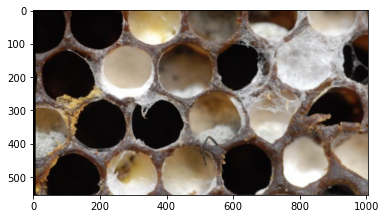

In [27]:
GenerateCaption("my_bee_pics/test/stonebrood.jpeg", feature_extractor, tokenizer, ViT)

CAPTION: ['yellow larva open brood cell'] AxesImage(54,36;334.8x217.44)


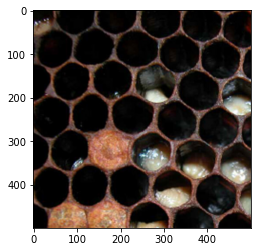

In [28]:
GenerateCaption("BEES_TEST/Unhealthy/506.png", feature_extractor, tokenizer, ViT)

CAPTION: ['caramel color larva sink cell'] AxesImage(54,36;334.8x217.44)


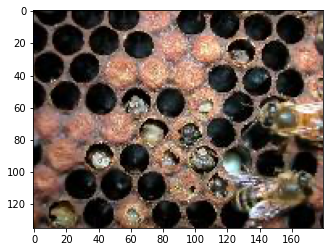

In [29]:
GenerateCaption("BEES_TEST/Unhealthy/511.png", feature_extractor, tokenizer, ViT)

CAPTION: ['spotty brood pattern'] AxesImage(54,36;334.8x217.44)


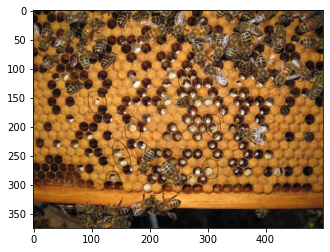

In [30]:
GenerateCaption("BEES_TEST/Unhealthy/525.png", feature_extractor, tokenizer, ViT)

CAPTION: ['brown larva open brood cell'] AxesImage(54,36;334.8x217.44)


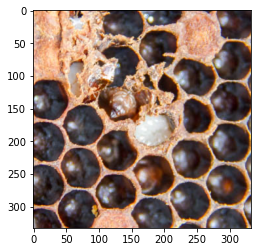

In [31]:
GenerateCaption("BEES_TEST/Unhealthy/521.png", feature_extractor, tokenizer, ViT)

CAPTION: ['white mummify larva open cell'] AxesImage(54,36;334.8x217.44)


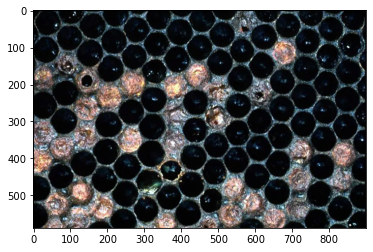

In [32]:
GenerateCaption("BEES_TEST/Unhealthy/504.png", feature_extractor, tokenizer, ViT)

#### Image Captioning Model 2: SWIN and our Pre-trained BERT

In [33]:
tokenizer, feature_extractor, train_dataset, eval_dataset = CaptioningModel(df['clean_captions'],
                                                                            df['file'],
                                                                            "bert-bees_final",
                                                                            "microsoft/swin-base-patch4-window7-224-in22k")

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file preprocessor_config.json from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/models--microsoft--swin-base-patch4-window7-224-in22k/snapshots/790d9b6014f6d157cc34d70afc0604eccc92dadd/preprocessor_config.json
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}



In [ ]:
batch_size=16

### Define encoder-decoder model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("microsoft/swin-base-patch4-window7-224-in22k",
                                                                  "bert-bees_final", tie_encoder_decoder=True)
    
## DEFINE PARAMS ##
# https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/vision-encoder-decoder#transformers.TFVisionEncoderDecoderModel
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.config.max_length = 20
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 1
model.config.num_beams = 4

In [35]:
# Create arguments for the Seq2SeqTrainer
training_args = Seq2SeqTrainingArguments(
    output_dir='swin-bert-bees-final',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    warmup_steps=100,  
    num_train_epochs = 15,
    save_total_limit=1,
    )


from transformers import default_data_collator

# Set up the trainer to fine tune the model
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
    )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [36]:
trainer.train()

/opt/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 155
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 150
  Number of trainable parameters = 225411570


***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  N

TrainOutput(global_step=150, training_loss=2.8617207845052084, metrics={'train_runtime': 1340.2115, 'train_samples_per_second': 1.735, 'train_steps_per_second': 0.112, 'total_flos': 4.232823443960832e+17, 'train_loss': 2.8617207845052084, 'epoch': 15.0})

In [37]:
swin_bert_bees = trainer.evaluate()
swin_bert_bees

***** Running Evaluation *****
  Num examples = 39
  Batch size = 16


{'eval_loss': 0.6369953751564026,
 'eval_rouge_result': {'rouge1': 0.2893050514091238,
  'rouge2': 0.03991307837461684,
  'rougeL': 0.2685905786018908,
  'rougeLsum': 0.27048387761057446},
 'eval_bleu_result': {'bleu': 0.0,
  'precisions': [0.3523809523809524,
   0.05847953216374269,
   0.022727272727272728,
   0.0],
  'brevity_penalty': 0.6735196583332465,
  'length_ratio': 0.7167235494880546,
  'translation_length': 210,
  'reference_length': 293},
 'eval_meteor_result': {'meteor': 0.16444158937867243},
 'eval_runtime': 12.5023,
 'eval_samples_per_second': 3.119,
 'eval_steps_per_second': 0.24,
 'epoch': 15.0}

In [38]:
trainer.save_model('swin-bert-bees-final')
tokenizer.save_pretrained('swin-bert-bees-final')

Saving model checkpoint to swin-bert-bees-final
Configuration saved in swin-bert-bees-final/config.json
Model weights saved in swin-bert-bees-final/pytorch_model.bin
Feature extractor saved in swin-bert-bees-final/preprocessor_config.json
tokenizer config file saved in swin-bert-bees-final/tokenizer_config.json
Special tokens file saved in swin-bert-bees-final/special_tokens_map.json


('swin-bert-bees-final/tokenizer_config.json',
 'swin-bert-bees-final/special_tokens_map.json',
 'swin-bert-bees-final/vocab.txt',
 'swin-bert-bees-final/added_tokens.json',
 'swin-bert-bees-final/tokenizer.json')

In [ ]:
ViT = VisionEncoderDecoderModel.from_pretrained('swin-bert-bees-final')

In [ ]:
from transformers import pipeline 

image_captioner = pipeline("image-to-text", model= 'swin-bert-bees-final')

In [41]:
image_captioner("my_bee_pics/test/stonebrood.jpeg")

/opt/miniconda3/lib/python3.9/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'white mummify larva sink cell'}]

CAPTION: ['white mummify larva sink cell'] AxesImage(54,36;334.8x217.44)


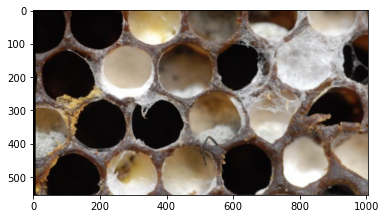

In [42]:
GenerateCaption("my_bee_pics/test/stonebrood.jpeg", feature_extractor, tokenizer, ViT)

In [43]:
image_captioner("BEES_TEST/Unhealthy/500.png")

[{'generated_text': 'spotty brood pattern'}]

CAPTION: ['spotty brood pattern'] AxesImage(54,36;334.8x217.44)


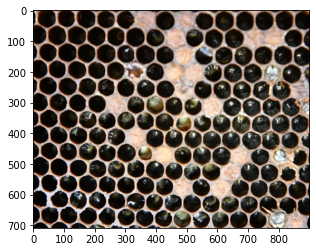

In [44]:
GenerateCaption("BEES_TEST/Unhealthy/500.png", feature_extractor, tokenizer, ViT)

In [45]:
image_captioner("BEES_TEST/Unhealthy/511.png")

[{'generated_text': 'white mummified larva'}]

CAPTION: ['white mummified larva'] AxesImage(54,36;334.8x217.44)


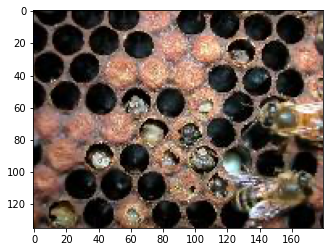

In [46]:
GenerateCaption("BEES_TEST/Unhealthy/511.png", feature_extractor, tokenizer, ViT)

CAPTION: ['spotty brood pattern'] AxesImage(54,36;334.8x217.44)


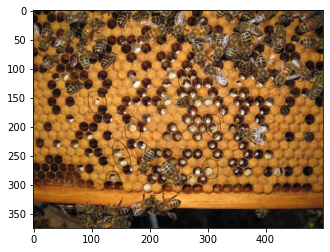

In [47]:
GenerateCaption("BEES_TEST/Unhealthy/525.png", feature_extractor, tokenizer, ViT)

CAPTION: ['caramel color larva sink cell'] AxesImage(54,36;334.8x217.44)


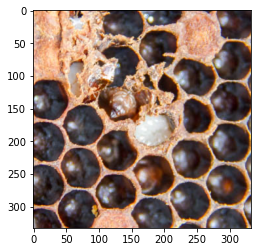

In [48]:
GenerateCaption("BEES_TEST/Unhealthy/521.png", feature_extractor, tokenizer, ViT)

CAPTION: ['white mummify larva sink cell'] AxesImage(54,36;334.8x217.44)


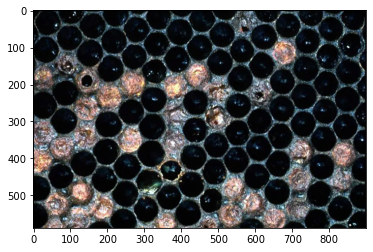

In [49]:
GenerateCaption("BEES_TEST/Unhealthy/504.png", feature_extractor, tokenizer, ViT)

#### Image Captioning Model 3: Google's ViT and our Pre-trained SciBERT

In [50]:
tokenizer, feature_extractor, train_dataset, eval_dataset = CaptioningModel(df['clean_captions'],
                                                                            df['file'],
                                                                            'scibert-bees-final',
                                                                            "google/vit-base-patch16-224-in21k")

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file preprocessor_config.json from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/preprocessor_config.json
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}



In [51]:
batch_size=16

### Define encoder-decoder model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k",
                                                                  "scibert-bees-final",
                                                                  tie_encoder_decoder=True)
    
## DEFINE PARAMS ##
# https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/vision-encoder-decoder#transformers.TFVisionEncoderDecoderModel
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.config.max_length = 20
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 1
model.config.num_beams = 4

loading configuration file config.json from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.24.0"
}

loading weights file pytorch_model.bin from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/pytorch_model.bin
All model checkpoint weights were

Setting `config.is_decoder=True` and `config.add_cross_attention=True` for decoder_config


In [52]:
# Create arguments for the Seq2SeqTrainer
training_args = Seq2SeqTrainingArguments(
    output_dir='vit-scibert-final',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    warmup_steps=100,  
    num_train_epochs = 15,
    save_total_limit=1,
    )


from transformers import default_data_collator

# Set up the trainer to fine tune the model
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
    )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [53]:
trainer.train()

/opt/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 155
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 150
  Number of trainable parameters = 224707186


***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  N

TrainOutput(global_step=150, training_loss=1.6695679728190105, metrics={'train_runtime': 1279.4089, 'train_samples_per_second': 1.817, 'train_steps_per_second': 0.117, 'total_flos': 4.208872208937984e+17, 'train_loss': 1.6695679728190105, 'epoch': 15.0})

In [54]:
vit_scibert_bees = trainer.evaluate()
vit_scibert_bees

***** Running Evaluation *****
  Num examples = 39
  Batch size = 16


{'eval_loss': 0.6747269034385681,
 'eval_rouge_result': {'rouge1': 0.2669760543629322,
  'rouge2': 0.01787101787101787,
  'rougeL': 0.2399469476392554,
  'rougeLsum': 0.2381768725660129},
 'eval_bleu_result': {'bleu': 0.0,
  'precisions': [0.29435483870967744,
   0.019138755980861243,
   0.0058823529411764705,
   0.0],
  'brevity_penalty': 0.8340586020013905,
  'length_ratio': 0.8464163822525598,
  'translation_length': 248,
  'reference_length': 293},
 'eval_meteor_result': {'meteor': 0.16661190950118213},
 'eval_runtime': 14.9655,
 'eval_samples_per_second': 2.606,
 'eval_steps_per_second': 0.2,
 'epoch': 15.0}

In [55]:
trainer.save_model('vit-scibert-final')
tokenizer.save_pretrained('vit-scibert-final')

Saving model checkpoint to vit-scibert-final
Configuration saved in vit-scibert-final/config.json
Model weights saved in vit-scibert-final/pytorch_model.bin
Feature extractor saved in vit-scibert-final/preprocessor_config.json
tokenizer config file saved in vit-scibert-final/tokenizer_config.json
Special tokens file saved in vit-scibert-final/special_tokens_map.json


('vit-scibert-final/tokenizer_config.json',
 'vit-scibert-final/special_tokens_map.json',
 'vit-scibert-final/vocab.txt',
 'vit-scibert-final/added_tokens.json',
 'vit-scibert-final/tokenizer.json')

In [56]:
ViT = VisionEncoderDecoderModel.from_pretrained('vit-scibert-final')

loading configuration file vit-scibert-final/config.json
Model config VisionEncoderDecoderConfig {
  "_commit_hash": null,
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "scibert-bees-final",
    "add_cross_attention": true,
    "architectures": [
      "BertForMaskedLM"
    ],
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 768,
    "id2label": {
      "0": "L

In [57]:
from transformers import pipeline 

image_captioner = pipeline("image-to-text", model='vit-scibert-final')

loading configuration file vit-scibert-final/config.json
Model config VisionEncoderDecoderConfig {
  "_commit_hash": null,
  "_name_or_path": "vit-scibert-final",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "scibert-bees-final",
    "add_cross_attention": true,
    "architectures": [
      "BertForMaskedLM"
    ],
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_siz

loading weights file vit-scibert-final/pytorch_model.bin
All model checkpoint weights were used when initializing VisionEncoderDecoderModel.

All the weights of VisionEncoderDecoderModel were initialized from the model checkpoint at vit-scibert-final.
If your task is similar to the task the model of the checkpoint was trained on, you can already use VisionEncoderDecoderModel for predictions without further training.
<class 'transformers.models.bert.modeling_bert.BertLMHeadModel'> and <class 'transformers.models.vit.modeling_vit.ViTModel'> are not equal. In this case make sure that all encoder weights are correctly initialized.
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/encoder', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/pooler']
loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading con

In [58]:
image_captioner("my_bee_pics/test/stonebrood.jpeg")

/opt/miniconda3/lib/python3.9/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'collection white larva gondola shape near cap brood'}]

CAPTION: ['collection white larva gondola shape near cap brood'] AxesImage(54,36;334.8x217.44)


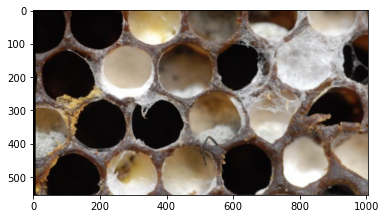

In [59]:
GenerateCaption("my_bee_pics/test/stonebrood.jpeg", feature_extractor, tokenizer, ViT)

CAPTION: ['hole capping chew larva'] AxesImage(54,36;334.8x217.44)


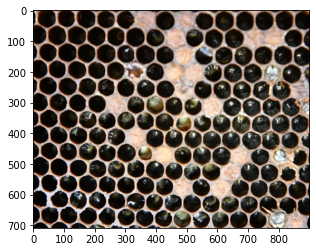

In [60]:
GenerateCaption("BEES_TEST/Unhealthy/500.png", feature_extractor, tokenizer, ViT)

CAPTION: ['caramel color larva open brood cell'] AxesImage(54,36;334.8x217.44)


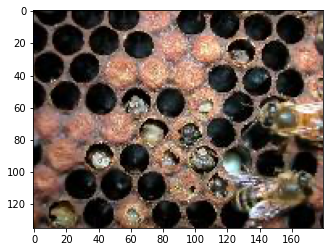

In [61]:
GenerateCaption("BEES_TEST/Unhealthy/511.png", feature_extractor, tokenizer, ViT)

CAPTION: ['unhealthy brown larva greasy cap brood cell'] AxesImage(54,36;334.8x217.44)


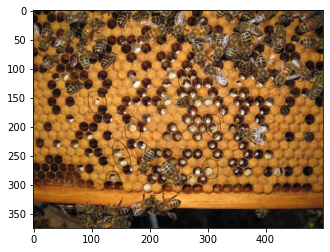

In [62]:
GenerateCaption("BEES_TEST/Unhealthy/525.png", feature_extractor, tokenizer, ViT)

CAPTION: ['caramel color larva damage open brood cell'] AxesImage(54,36;334.8x217.44)


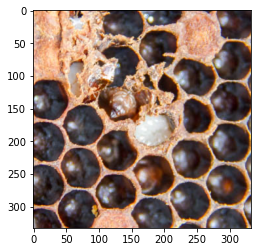

In [63]:
GenerateCaption("BEES_TEST/Unhealthy/521.png", feature_extractor, tokenizer, ViT)

CAPTION: ['combination cap brood cell'] AxesImage(54,36;334.8x217.44)


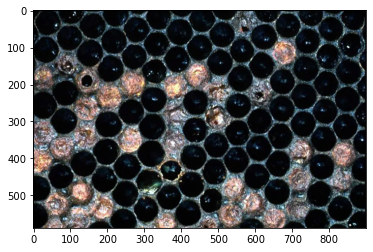

In [64]:
GenerateCaption("BEES_TEST/Unhealthy/504.png", feature_extractor, tokenizer, ViT)

#### Image Captioning Model 4: Google's ViT and GPT2

In [65]:
tokenizer, feature_extractor, train_dataset, eval_dataset = CaptioningModel(df['clean_captions'],
                                                                            df['file'],
                                                                            "gpt2",
                                                                            "google/vit-base-patch16-224-in21k")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/models--gpt2/snapshots/f27b190eeac4c2302d24068eabf5e9d6044389ae/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_pa

In [66]:
batch_size=16

### Define encoder-decoder model
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k",
                                                                  "gpt2", 
                                                                  tie_encoder_decoder=True)
    
## Model set up for GPT2 training
## Source: https://ankur3107.github.io/blogs/the-illustrated-image-captioning-using-transformers/

# Since GPT2 does not have PAD tokens
tokenizer.pad_token = tokenizer.eos_token

model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id

model.config.max_length = 20 # max length of sequence to be generated
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 1
model.config.num_beams = 4

loading configuration file config.json from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.24.0"
}

loading weights file pytorch_model.bin from cache at /Users/elizabethtrahadias/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/pytorch_model.bin
All model checkpoint weights were

In [67]:
# Create arguments for the Seq2Seq model
training_args = Seq2SeqTrainingArguments(
    output_dir='vit-gpt2-final',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    warmup_steps=100,  
    num_train_epochs = 15,
    save_total_limit=1,
    )


from transformers import default_data_collator

# Set up the trainer to fine tune the model
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
    )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [68]:
trainer.train()

/opt/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 155
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 150
  Number of trainable parameters = 239195904


***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  Num examples = 39
  Batch size = 16
***** Running Evaluation *****
  N

TrainOutput(global_step=150, training_loss=1.5727290852864584, metrics={'train_runtime': 2164.4212, 'train_samples_per_second': 1.074, 'train_steps_per_second': 0.069, 'total_flos': 4.195785468542976e+17, 'train_loss': 1.5727290852864584, 'epoch': 15.0})

In [69]:
vit_gpt2 = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 39
  Batch size = 16


In [70]:
vit_gpt2

{'eval_loss': 0.6943862438201904,
 'eval_rouge_result': {'rouge1': 0.23374752167391266,
  'rouge2': 0.032510546442434986,
  'rougeL': 0.1964731279599352,
  'rougeLsum': 0.19584257383087725},
 'eval_bleu_result': {'bleu': 0.01779148146866288,
  'precisions': [0.17884615384615385,
   0.02494802494802495,
   0.00904977375565611,
   0.0024813895781637717],
  'brevity_penalty': 1.0,
  'length_ratio': 1.7747440273037542,
  'translation_length': 520,
  'reference_length': 293},
 'eval_meteor_result': {'meteor': 0.19905885362469836},
 'eval_runtime': 26.1195,
 'eval_samples_per_second': 1.493,
 'eval_steps_per_second': 0.115,
 'epoch': 15.0}

In [71]:
trainer.save_model('vit-gpt2-final')
tokenizer.save_pretrained('vit-gpt2-final')
ViT = VisionEncoderDecoderModel.from_pretrained('vit-gpt2-final')

Saving model checkpoint to vit-gpt2-final
Configuration saved in vit-gpt2-final/config.json
Model weights saved in vit-gpt2-final/pytorch_model.bin
Feature extractor saved in vit-gpt2-final/preprocessor_config.json
tokenizer config file saved in vit-gpt2-final/tokenizer_config.json
Special tokens file saved in vit-gpt2-final/special_tokens_map.json
loading configuration file vit-gpt2-final/config.json
Model config VisionEncoderDecoderConfig {
  "_commit_hash": null,
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "gpt2",
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 50256,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": fa

In [72]:
from transformers import pipeline 

image_captioner = pipeline("image-to-text", model='vit-gpt2-final')

loading configuration file vit-gpt2-final/config.json
Model config VisionEncoderDecoderConfig {
  "_commit_hash": null,
  "_name_or_path": "vit-gpt2-final",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "gpt2",
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 50256,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 50256,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
    },
    "initia

loading weights file vit-gpt2-final/pytorch_model.bin
All model checkpoint weights were used when initializing VisionEncoderDecoderModel.

All the weights of VisionEncoderDecoderModel were initialized from the model checkpoint at vit-gpt2-final.
If your task is similar to the task the model of the checkpoint was trained on, you can already use VisionEncoderDecoderModel for predictions without further training.
<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> and <class 'transformers.models.vit.modeling_vit.ViTModel'> are not equal. In this case make sure that all encoder weights are correctly initialized.
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/encoder', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/pooler']
loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_conf

In [73]:
image_captioner("my_bee_pics/test/stonebrood.jpeg")

/opt/miniconda3/lib/python3.9/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'red varroa mite yellow larva gondola shape near light brown cap brood cell'}]

CAPTION: ['red varroa mite yellow larva gondola shape near light brown cap brood cell'] AxesImage(54,36;334.8x217.44)


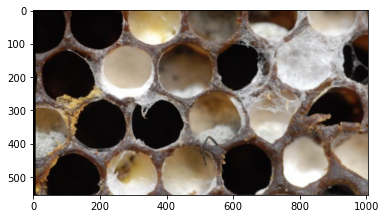

In [74]:
GenerateCaption("my_bee_pics/test/stonebrood.jpeg", feature_extractor, tokenizer, ViT)

CAPTION: ['gondola shape larva see open brood cell near cap hole capping misshapen larvae'] AxesImage(54,36;334.8x217.44)


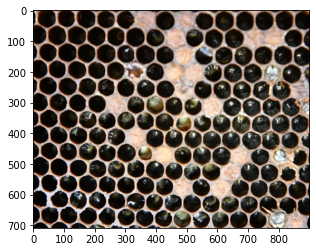

In [75]:
GenerateCaption("BEES_TEST/Unhealthy/500.png", feature_extractor, tokenizer, ViT)

CAPTION: ['diseased larva see brown cap brood cell bee varroa mite decompose near'] AxesImage(54,36;334.8x217.44)


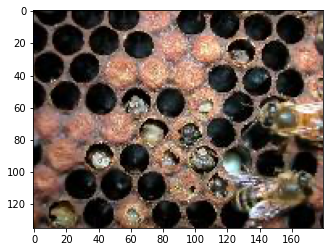

In [76]:
GenerateCaption("BEES_TEST/Unhealthy/511.png", feature_extractor, tokenizer, ViT)

CAPTION: ['diseased larva see brown cap brood cell bee frame unhealthy hive varroa mite'] AxesImage(54,36;334.8x217.44)


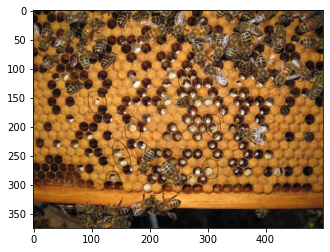

In [77]:
GenerateCaption("BEES_TEST/Unhealthy/525.png", feature_extractor, tokenizer, ViT)

CAPTION: ['gondola shape larva sit cell near light brown spotty brood pattern open mummify'] AxesImage(54,36;334.8x217.44)


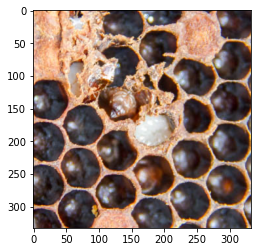

In [78]:
GenerateCaption("BEES_TEST/Unhealthy/521.png", feature_extractor, tokenizer, ViT)

CAPTION: ['gondola shape larva see cap brood cell bee unhealthy honey comb damage mummified individual'] AxesImage(54,36;334.8x217.44)


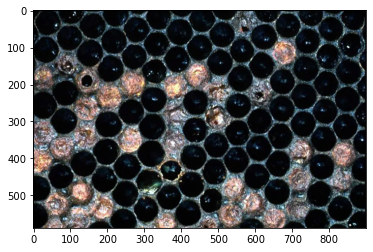

In [79]:
GenerateCaption("BEES_TEST/Unhealthy/504.png", feature_extractor, tokenizer, ViT)

### Compare Model Performance

In [80]:
def ExtractResults(model_name):
    return([model_name['eval_loss'],
       model_name['eval_rouge_result']['rouge1'],
       model_name['eval_rouge_result']['rouge2'],
       model_name['eval_rouge_result']['rougeL'],
       model_name['eval_bleu_result']['bleu'],
       model_name['eval_meteor_result']['meteor']]
    )

In [81]:
vit_bert_bees_results = ExtractResults(vit_bert_bees)
vit_bert_bees_results

[0.6292902827262878,
 0.27766861511205404,
 0.0369349311657004,
 0.24327645289183747,
 0.0,
 0.14410297953591264]

In [82]:
swin_bert_bees_results = ExtractResults(swin_bert_bees)
swin_bert_bees_results

[0.6369953751564026,
 0.2893050514091238,
 0.03991307837461684,
 0.2685905786018908,
 0.0,
 0.16444158937867243]

In [83]:
vit_scibert_bees_results = ExtractResults(vit_scibert_bees)
vit_scibert_bees_results

[0.6747269034385681,
 0.2669760543629322,
 0.01787101787101787,
 0.2399469476392554,
 0.0,
 0.16661190950118213]

In [84]:
vit_gpt2_results = ExtractResults(vit_gpt2)
vit_gpt2_results

[0.6943862438201904,
 0.23374752167391266,
 0.032510546442434986,
 0.1964731279599352,
 0.01779148146866288,
 0.19905885362469836]

In [85]:
caption_results = pd.DataFrame({"vit_bert_bees": vit_bert_bees_results, 
                               "swin_bert_bees": swin_bert_bees_results,
                                "vit_scibert_bees": vit_scibert_bees_results,
                                "vit_gpt2": vit_gpt2_results}
                               )
caption_results

vit_bert_bees  swin_bert_bees  vit_scibert_bees  vit_gpt2
0       0.629290        0.636995          0.674727  0.694386
1       0.277669        0.289305          0.266976  0.233748
2       0.036935        0.039913          0.017871  0.032511
3       0.243276        0.268591          0.239947  0.196473
4       0.000000        0.000000          0.000000  0.017791
5       0.144103        0.164442          0.166612  0.199059

In [86]:
caption_results.index=['eval_loss', 'rouge1', 'rouge2', 'rougeL', 'bleu', 'meteor']
caption_results

vit_bert_bees  swin_bert_bees  vit_scibert_bees  vit_gpt2
eval_loss       0.629290        0.636995          0.674727  0.694386
rouge1          0.277669        0.289305          0.266976  0.233748
rouge2          0.036935        0.039913          0.017871  0.032511
rougeL          0.243276        0.268591          0.239947  0.196473
bleu            0.000000        0.000000          0.000000  0.017791
meteor          0.144103        0.164442          0.166612  0.199059

In [87]:
caption_results_T = caption_results.T
caption_results_T.reset_index(inplace=True)
caption_results_T.rename(columns = {'index':'model'}, inplace=True)
caption_results_T

model  eval_loss    rouge1    rouge2    rougeL      bleu  \
0     vit_bert_bees   0.629290  0.277669  0.036935  0.243276  0.000000   
1    swin_bert_bees   0.636995  0.289305  0.039913  0.268591  0.000000   
2  vit_scibert_bees   0.674727  0.266976  0.017871  0.239947  0.000000   
3          vit_gpt2   0.694386  0.233748  0.032511  0.196473  0.017791   

     meteor  
0  0.144103  
1  0.164442  
2  0.166612  
3  0.199059

In [88]:
import seaborn as sns

long_table = pd.melt(caption_results_T, id_vars='model', value_vars=['eval_loss', 
                                                                     'rouge1',
                                                                     'rouge2',
                                                                     'rougeL',
                                                                     'bleu',
                                                                     'meteor'])
long_table.rename(columns = {'variable':'Metric'}, inplace=True)

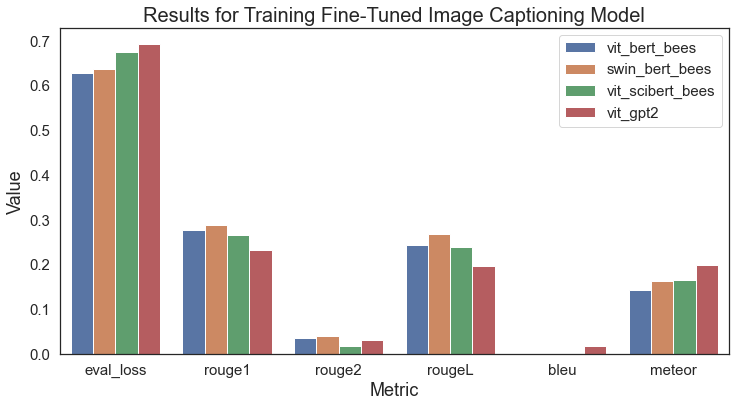

In [89]:
import matplotlib.pyplot as plt

sns.set_theme(style="white")
plt.figure(figsize=(12,6))
plt.title("Results for Training Fine-Tuned Image Captioning Model", fontsize=20)
sns.barplot(data=long_table, x="Metric", y='value', hue="model")
plt.xlabel('Metric',fontsize=18);
plt.ylabel('Value', fontsize=18);
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=15)
plt.show()

This chart summarizes the performance of our different image captioning models. Our model was trained on 155 examples, and these test results are from evaluating on the 39 test set examples.